# Recommendations with IBM

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Conclusions](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [35]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
user_article = df.groupby('email')['title'].count()

In [4]:
user_article.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: title, dtype: float64

(array([4.915e+03, 1.670e+02, 4.600e+01, 1.100e+01, 7.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  1. ,  37.3,  73.6, 109.9, 146.2, 182.5, 218.8, 255.1, 291.4,
        327.7, 364. ]),
 <a list of 10 Patch objects>)

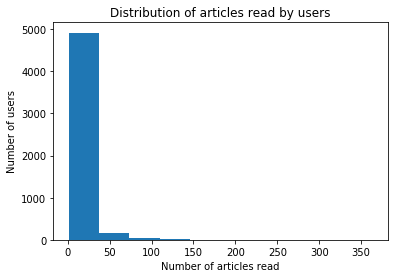

In [5]:
plt.title('Distribution of articles read by users')
plt.xlabel('Number of articles read')
plt.ylabel('Number of users')

plt.hist(user_article)

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
for col in df_content.columns:
    print('There are {} duplicates in {}'.format(df_content[col].duplicated().sum(), col))

There are 19 duplicates in doc_body
There are 33 duplicates in doc_description
There are 5 duplicates in doc_full_name
There are 1055 duplicates in doc_status
There are 5 duplicates in article_id


In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates('article_id', inplace=True)

In [9]:
for col in df_content.columns:
    print('There are {} duplicates in {}'.format(df_content[col].duplicated().sum(), col))

There are 19 duplicates in doc_body
There are 31 duplicates in doc_description
There are 0 duplicates in doc_full_name
There are 1050 duplicates in doc_status
There are 0 duplicates in article_id


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
#The number of unique articles that have an interaction with a user.
interactions = df[~df['email'].isnull()]
interactions['article_id'].nunique()

714

In [11]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content['article_id'].nunique()

1051

In [12]:
# The number of unique users in the dataset. (excluding null values)
interactions['email'].nunique()

5148

In [13]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

In [14]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [15]:
df['article_id'].value_counts().sort_values(ascending=False).head(1)

1429.0    937
Name: article_id, dtype: int64

In [16]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [17]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby(df['title'])['user_id'].count().sort_values(ascending=False).head(n).index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_list = list(df.groupby(df['article_id'])['user_id'].count().sort_values(ascending=False).head(n).index)
    top_articles = list(map(str, top_articles_list))
    
    return top_articles # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    #transform df into user by item pandas with counts as values
    user_item = pd.pivot_table(df, index=['user_id'], columns=['article_id'], aggfunc='count')
    
    #substitute NaN's with 0's
    user_item.fillna(value=0, inplace=True)
    
    #change counts in to 1's
    for col in user_item.columns.values:
        user_item[col] = user_item[col].apply(lambda x: x if x == 0 else 1)

    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod_user_item = user_item.dot(np.transpose(user_item))
    
    # sort by similarity
    similar_users_idx = dot_prod_user_item[user_id].sort_values(ascending=False).index


    # create list of just the ids
    most_similar_users = list(similar_users_idx)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = [df[df['article_id']==float(article)]['title'].unique()[0] for article in article_ids]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids_list = list(user_item.loc[user_id][user_item.loc[user_id]==1].index.get_level_values(1))
    article_ids = list(map(str, article_ids_list))
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    for similar in find_similar_users(user_id):
        recs_similar, _ = get_user_articles(similar)
        recs_user, _ = get_user_articles(user_id)
        recs = set(recs_similar).difference(set(recs_user))
        no_of_recs = len(recs)
        if no_of_recs > m:
            break

    recs = list(recs)[:m]
    
    return recs # return your recommendations for this user_id

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'from scikit-learn model to cloud with wml client',
 'get started with streams designer by following this roadmap',
 'python machine learning: scikit-learn tutorial',
 'deploy your python model as a restful api',
 'brunel in jupyter',
 'a dynamic duo – inside machine learning – medium',
 'leverage python, scikit, and text classification for behavioral profiling',
 'experience iot with coursera']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # compute similarity of each user to the provided user
    dot_prod_user_item = user_item.dot(np.transpose(user_item))
    
    neighbors_df = pd.DataFrame(index = dot_prod_user_item.index)
    
    neighbors_df['neighbor_id'] = dot_prod_user_item.index
    neighbors_df['similarity'] = dot_prod_user_item[user_id]
    neighbors_df['num_interactions'] = df.groupby('user_id')['article_id'].count()

    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    neighbors_df.drop(index=user_id, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    
    for similar in get_top_sorted_users(user_id)['neighbor_id']:
        recs_similar, _ = get_user_articles(similar)
        recs_user, _ = get_user_articles(user_id)
        diff = set(recs_similar).difference(set(recs_user))
        no_of_recs = len(diff)
        if no_of_recs > m:
            break

    recs_list = list(diff)
    recs_df = df[df['article_id'].isin(recs_list)]
    recs = list(recs_df.groupby(recs_df['article_id'])['user_id'].count().sort_values(ascending=False).index)[:m]
    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results
#get_top_sorted_users(1)['neighbor_id'].iloc[0]
#get_top_sorted_users(131)['neighbor_id'].iloc[9]
user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

New user has no interactions with existing content, hence she has no neighbours. In such a case user based collaborative filtering won't work, so we have only rank-based recommendations at hand. Thus, for a new user I recommend to use *get_top_article* function.

Alternatively, during user on-boarding phase we can ask few questions on user interest, and basing on these answers recommend content categorized by chosen keywords. That would require some kind of NLP work (identification of TAGs and appropriate content classification).

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = set(get_top_article_ids(10))



In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

The matrix used in the lesson has NaN's for videos not ranked by user - SVD won't work for such matrices. In our case *user_item_matrix* contains no NaN's, and we can perform SVD without any problems.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

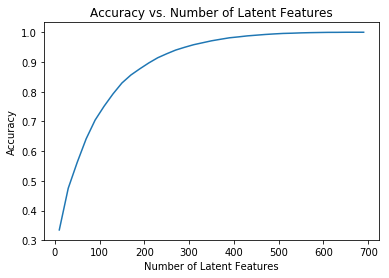

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
#'How many users can we make predictions for in the test set?'
# equals: How many users in a test set is also in a train test?
# method: count users in a test df which apear also in a test df > use: set > intersection
len(set(df_train['user_id'].unique()).intersection(set(df_test['user_id'].unique())))

20

In [42]:
#'How many users in the test set are we not able to make predictions for because of the cold start problem?'
# equals: How many users in a test set are new to us. Read: are absent in a train test?
# method: count users in a test df which apear are not in a test df. Simply compute the difference between sets

In [43]:
len(set(df_test['user_id'].unique()).difference(set(df_train['user_id'].unique())))

662

In [44]:
# 'How many articles can we make predictions for in the test set?'
# Proceed by analogy to users
len(set(df_train['article_id'].unique()).intersection(set(df_test['article_id'].unique())))

574

In [45]:
#'How many articles in the test set are we not able to make predictions for because of the cold start problem?'
# Proceed by analogy to users
len(set(df_test['article_id'].unique()).difference(set(df_train['article_id'].unique())))

0

In [46]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

### Goals
Plot Accuracy vs k (no of latent features) for:
- a train dataset
- a test dataset
- a whole dataset.

### Strategy

1. **Fit SVD with user_item_train**. Use the user_item_train dataset from above to find U, S, and V transpose using SVD

2.  **Find the subset of rows in the user_item_test dataset that you can predict** using this matrix decomposition with different numbers of latent features

3. **Plot Accuracy vs no of latent features** for train, test and whole datasets.

### Objects we have at hand

**df**: all user-articles interaction (dataframe)

**df_train**: first 40K records of df with user-articles interaction (dataframe)

**df_test**: tail 6K records of df with user-articles interaction (dataframe)

**user_item_train**: user by item matrix with 0/1 for interactions at crossings, for a training dataset (first 40K records of df) (np array)

**user_item_test**: user by item matrix with 0/1 for interactions at crossings, for a test dataset (tail 6k records of df) (np array)

**test_idx**: indices of users in a test dataset (np array)

**test_arts**: indices of articles in a test dataset (np array)

In [47]:
df.shape, df_train.shape, df_test.shape

((45993, 3), (40000, 3), (5993, 3))

In [48]:
user_item_train.shape, user_item_test.shape, test_idx.shape, test_arts.shape

((4487, 714), (682, 574), (682,), (574,))

In [49]:
test_idx[:10] #user_item_test.index.values

array([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801])

In [50]:
test_arts[:10] #user_item_test.columns.values

array([('title', 0.0), ('title', 2.0), ('title', 4.0), ('title', 8.0),
       ('title', 9.0), ('title', 12.0), ('title', 14.0), ('title', 15.0),
       ('title', 16.0), ('title', 18.0)], dtype=object)

### Deployment

#### Fit SVD on the user_item_train matrix

In [51]:
#full_matrices = False because of future predictions dimensions requirements
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False) 

In [52]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

#### Identify a subset of user_item_test dataset to predict

1. in *user_item_train* np array we store data about 4487 unique users and 714 unique articles

2. in *user_item_test* np array we store data about 682 unique users and 574 unique articles

3. We will be able to make predictions for: 
    - users from *user_item_test* which also appear in *user_item_train* 
    - articles from *user_item_test* which also appear in *user_item_train* 

4. In order to identify a proper subset of *user_item_test* we need to:
    - identify indices of users which appear in both *user_item_train* and *user_item_test*: *users_2_predict_idx* 
    - identify indices of articles which appear in both *user_item_train* and *user_item_test*: *arts_2_predict_idx* 

5. Having these indices, we will make a proper slice of *user_item_test*:

*user_item_2predict* = user_item_test.loc[users_2_predict_idx, arts_2_predict_idx]

In [53]:
# identify users_2_predict_idx
users_2_predict_idx = np.intersect1d(user_item_train.index.values, user_item_test.index.values)
users_2_predict_idx.shape

(20,)

In [54]:
# identify arts_2_predict_idx
arts_2_predict_idx = np.intersect1d(user_item_train.columns.values, user_item_test.columns.values)
arts_2_predict_idx.shape

(574,)

In [55]:
# make a subset of user_item_test by making a proper slice
user_item_2predict = user_item_test.loc[users_2_predict_idx, arts_2_predict_idx]
user_item_2predict.shape

(20, 574)

#### Plot Accuracy vs no of latent features for train, test and whole datasets.

In [56]:
#Identify subsets on u_train (users) and vt_train (articles) levels. 
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

In [57]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_test = []
sum_errs_train = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new_test, u_new_test, vt_new_test = np.diag(s[:k]), u_test[:, :k], vt_test[:k, :]
    s_new_train, u_new_train, vt_new_train = np.diag(s[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_test), vt_new_test))
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_2predict, user_item_est_test)
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    
    # total errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)

In [58]:
# compute no of interactions to "normalize" accuracy in the plot below
train_interactions = user_item_train.shape[0]*user_item_train.shape[1]
test_interactions = user_item_2predict.shape[0]*user_item_2predict.shape[1]

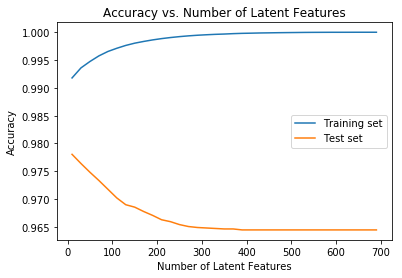

In [59]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/train_interactions, label='Training set');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/test_interactions, label='Test set');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
leg = plt.legend();

# <a class="anchor" id="conclusions"> Conclusions

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the plot of 'Accurace vs Number of Latent Features' we can deduce that:
1. Accurracy is quite good (app. .985)
2. With increasing the number of latent feature a training set accuracy increases, by test set accuracy decreases.

Thus, just looking at the graph it looks like 100 latent features seems to be a reasonable trade-off. The real problem is that with only 20 users for which we can make predictions it is not statistically significant. That's why we need a bit different approach to finding an optimum k and, in general, recommendation algorithm.

A/B testing seems to be an interesting next step. We can test different versions of our algorithm with null hypothesis stating that it won't increase the user/article interaction and alternative one that it will increase overall number of interactions. 